In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import unicodedata
import markdown
import re
import nltk
import os
import prepare as p
import preprocess as pre

from requests import get
from bs4 import BeautifulSoup

from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report


In [2]:
df = pd.read_csv('all_repos.csv')

In [3]:
df.iloc[686]

repo               mattwaite/NICAR19SportsDataViz
language                                      NaN
readme_contents                               NaN
Name: 686, dtype: object

In [4]:
df.isnull().sum()

repo                0
language           72
readme_contents     1
dtype: int64

In [5]:
df.dropna(inplace = True)

In [6]:
df = df[df.readme_contents != 'failedreadme']

In [7]:
df.shape

(883, 3)

In [8]:
df.head()

,repo,language,readme_contents
0,ScottfreeLLC/AlphaPy,Python,AlphaPy\n=======\n\n|badge_pypi| |badge_downlo...
1,jalapic/engsoccerdata,R,"Latest GitHub version: 11/4/2022, v0.1.7\n\nN..."
2,bttmly/nba,JavaScript,# nba\n*Node.js client for nba.com API endpoin...
3,kyleskom/NBA-Machine-Learning-Sports-Betting,Python,# NBA Sports Betting Using Machine Learning 🏀\...
4,linouk23/NBA-Player-Movements,Python,# NBA Player Movements\n\nThis is a script for...


In [9]:
df.language.value_counts()

Python               232
JavaScript           141
Jupyter Notebook      86
R                     43
TypeScript            40
HTML                  40
Java                  39
PHP                   35
Ruby                  30
C#                    24
C++                   22
Dart                  22
Kotlin                20
CSS                   19
Vue                   10
Objective-C           10
Swift                 10
Go                     9
Rust                   6
XSLT                   4
TeX                    3
Shell                  3
Solidity               3
C                      3
Elixir                 3
CoffeeScript           2
MATLAB                 2
Visual Basic .NET      2
Svelte                 2
EJS                    2
Matlab                 2
Scala                  2
Haskell                1
Stata                  1
Visual Basic           1
Haxe                   1
Dockerfile             1
XML                    1
Max                    1
Batchfile              1


# Many of these are not commonly used and some are not actual program languages. I need to either remove or categorize some of these into 'other'

In [10]:
valid_languages = ["Python", 'HTML', "JavaScript", "R", "Java", "TypeScript", "PHP", "Ruby", "C#", "C++", "Dart", "Kotlin", "Objective-C", "Swift", "Go", "Rust", "C", "Elixir", "CoffeeScript", "MATLAB", "Visual Basic .NET", "Scala", "Haskell", "Stata", "Haxe", "Lua", "Perl", "Clojure"]

# Use the isin method to filter the DataFrame
df = df[df['language'].isin(valid_languages)]

df.head()


,repo,language,readme_contents
0,ScottfreeLLC/AlphaPy,Python,AlphaPy\n=======\n\n|badge_pypi| |badge_downlo...
1,jalapic/engsoccerdata,R,"Latest GitHub version: 11/4/2022, v0.1.7\n\nN..."
2,bttmly/nba,JavaScript,# nba\n*Node.js client for nba.com API endpoin...
3,kyleskom/NBA-Machine-Learning-Sports-Betting,Python,# NBA Sports Betting Using Machine Learning 🏀\...
4,linouk23/NBA-Player-Movements,Python,# NBA Player Movements\n\nThis is a script for...


In [11]:
df.language.value_counts()

Python               232
JavaScript           141
R                     43
TypeScript            40
HTML                  40
Java                  39
PHP                   35
Ruby                  30
C#                    24
Dart                  22
C++                   22
Kotlin                20
Swift                 10
Objective-C           10
Go                     9
Rust                   6
C                      3
Elixir                 3
Visual Basic .NET      2
MATLAB                 2
CoffeeScript           2
Scala                  2
Perl                   1
Lua                    1
Haskell                1
Haxe                   1
Stata                  1
Clojure                1
Name: language, dtype: int64

In [12]:
df.language.value_counts()[df.language.value_counts() < 46].sum()

370

In [13]:
# List of languages to rename to 'other'
languages_to_rename = ['HTML', 'Java', 'PHP', 'Ruby', 'C#', 'C++', 'Dart', 'Kotlin', 'Objective-C', 'Swift', 'Go', 'Rust', 'C', 'Elixir', 'Visual Basic .NET', 'MATLAB', 'CoffeeScript', 'Scala', 'Perl', 'Lua', 'Haskell', 'Haxe', 'Stata', 'Clojure']

# Replace the specified languages with 'other'
df['language'] = df['language'].replace(languages_to_rename, 'other')


In [14]:
df.language.value_counts()

other         287
Python        232
JavaScript    141
R              43
TypeScript     40
Name: language, dtype: int64

In [15]:
labels = pd.concat([df.language.value_counts(),
                    df.language.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']
labels

,n,percent
other,287,0.386272
Python,232,0.312248
JavaScript,141,0.189771
R,43,0.057873
TypeScript,40,0.053836


In [16]:
df.shape

(743, 3)

# Clean

In [17]:
python_words = p.advanced_clean(' '.join(df[df.language == 'Python']['readme_contents']), l = True, extra_words = ['python', 'eww', 'sport']).split()
javascript_words = p.advanced_clean(' '.join(df[df.language == 'JavaScript']['readme_contents']), l = True).split()
other_words = p.advanced_clean(' '.join(df[df.language == 'other']['readme_contents']), l = True).split()
all_words = p.advanced_clean(' '.join(df.readme_contents), l = True).split()

Removed 35126 stopwords
---
Removed 21314 stopwords
---
Removed 21017 stopwords
---
Removed 71780 stopwords
---


In [18]:
python_words

['alphapy',
 'badgepypi',
 'badgedownloads',
 'badgedocs',
 'badgebuild',
 'alphapy',
 'machine',
 'learning',
 'framework',
 'speculator',
 'data',
 'scientist',
 'written',
 'mainly',
 'scikitlearn',
 'panda',
 'library',
 'well',
 'many',
 'helpful',
 'package',
 'feature',
 'engineering',
 'visualization',
 'thing',
 'alphapy',
 'run',
 'machine',
 'learning',
 'model',
 'using',
 'scikitlearn',
 'kera',
 'xgboost',
 'lightgbm',
 'catboost',
 'generate',
 'blended',
 'stacked',
 'ensemble',
 'create',
 'model',
 'analyzing',
 'market',
 'marketflow',
 'predict',
 'sporting',
 'event',
 'sportflow',
 'develop',
 'trading',
 'system',
 'analyze',
 'portfolio',
 'using',
 'marketflow',
 'quantopians',
 'pyfolio',
 'image',
 'width',
 '100',
 'alt',
 'alphapy',
 'model',
 'pipeline',
 'align',
 'center',
 'documentation',
 'installation',
 'already',
 'pip',
 'optionally',
 'xgboost',
 'lightgbm',
 'catboost',
 'installed',
 'system',
 'see',
 'run',
 'following',
 'command',
 'install

In [19]:
python_freq = pd.Series(python_words).value_counts()
javascript_freq = pd.Series(javascript_words).value_counts()
other_freq = pd.Series(other_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [20]:
python_freq

barry             746
data              541
file              510
team              361
bee               361
                 ... 
1200                1
raining             1
resumebrochure      1
wistful             1
cvnlpendterm        1
Length: 13907, dtype: int64

In [21]:
len(javascript_freq.index.values)

9314

In [22]:
other_freq

get                  1208
team                  561
player                401
data                  391
database              356
                     ... 
resignin                1
showcase                1
asianoddsplacebet       1
192                     1
optionally              1
Length: 10671, dtype: int64

In [23]:
all_freq

data          1181
team           987
file           904
sport          886
game           797
              ... 
messenger        1
bungee           1
cord             1
slingshot        1
replicated       1
Length: 26456, dtype: int64

In [24]:
len(python_freq), len(javascript_freq), len(other_freq), len(all_freq)

(13907, 9314, 10671, 26456)

In [25]:
df.head()

,repo,language,readme_contents
0,ScottfreeLLC/AlphaPy,Python,AlphaPy\n=======\n\n|badge_pypi| |badge_downlo...
1,jalapic/engsoccerdata,R,"Latest GitHub version: 11/4/2022, v0.1.7\n\nN..."
2,bttmly/nba,JavaScript,# nba\n*Node.js client for nba.com API endpoin...
3,kyleskom/NBA-Machine-Learning-Sports-Betting,Python,# NBA Sports Betting Using Machine Learning 🏀\...
4,linouk23/NBA-Player-Movements,Python,# NBA Player Movements\n\nThis is a script for...


In [26]:
python_freq = python_freq[python_freq > 50]
javascript_freq = javascript_freq[javascript_freq > 50]
other_freq = other_freq[other_freq > 50]

len(python_freq), len(javascript_freq), len(other_freq)

(205, 122, 156)

In [27]:
extra_words = (pd.Series(all_words).value_counts()[pd.Series(all_words).value_counts() < 20]).index

In [28]:
list(nltk.bigrams(python_words))

[('alphapy', 'badgepypi'),
 ('badgepypi', 'badgedownloads'),
 ('badgedownloads', 'badgedocs'),
 ('badgedocs', 'badgebuild'),
 ('badgebuild', 'alphapy'),
 ('alphapy', 'machine'),
 ('machine', 'learning'),
 ('learning', 'framework'),
 ('framework', 'speculator'),
 ('speculator', 'data'),
 ('data', 'scientist'),
 ('scientist', 'written'),
 ('written', 'mainly'),
 ('mainly', 'scikitlearn'),
 ('scikitlearn', 'panda'),
 ('panda', 'library'),
 ('library', 'well'),
 ('well', 'many'),
 ('many', 'helpful'),
 ('helpful', 'package'),
 ('package', 'feature'),
 ('feature', 'engineering'),
 ('engineering', 'visualization'),
 ('visualization', 'thing'),
 ('thing', 'alphapy'),
 ('alphapy', 'run'),
 ('run', 'machine'),
 ('machine', 'learning'),
 ('learning', 'model'),
 ('model', 'using'),
 ('using', 'scikitlearn'),
 ('scikitlearn', 'kera'),
 ('kera', 'xgboost'),
 ('xgboost', 'lightgbm'),
 ('lightgbm', 'catboost'),
 ('catboost', 'generate'),
 ('generate', 'blended'),
 ('blended', 'stacked'),
 ('stacked',

In [29]:
list(nltk.bigrams(javascript_words))

[('nba', 'nodejs'),
 ('nodejs', 'client'),
 ('client', 'nbacom'),
 ('nbacom', 'api'),
 ('api', 'endpoint'),
 ('endpoint', 'npm'),
 ('npm', 'install'),
 ('install', 'nba'),
 ('nba', 'note'),
 ('note', 'blacklisted'),
 ('blacklisted', 'ip'),
 ('ip', 'address'),
 ('address', 'appears'),
 ('appears', 'though'),
 ('though', 'nba'),
 ('nba', 'blacklisted'),
 ('blacklisted', 'certain'),
 ('certain', 'block'),
 ('block', 'ip'),
 ('ip', 'address'),
 ('address', 'specifically'),
 ('specifically', 'cloud'),
 ('cloud', 'hosting'),
 ('hosting', 'provider'),
 ('provider', 'including'),
 ('including', 'aws'),
 ('aws', 'may'),
 ('may', 'hit'),
 ('hit', 'situation'),
 ('situation', 'application'),
 ('application', 'using'),
 ('using', 'package'),
 ('package', 'work'),
 ('work', 'fine'),
 ('fine', 'local'),
 ('local', 'machine'),
 ('machine', 'doesnt'),
 ('doesnt', 'work'),
 ('work', 'deployed'),
 ('deployed', 'cloud'),
 ('cloud', 'server'),
 ('server', 'annoyingly'),
 ('annoyingly', 'request'),
 ('requ

In [30]:
list(nltk.bigrams(other_words))

[('toc', 'easysports'),
 ('easysports', 'apinbanba'),
 ('apinbanba', 'nba'),
 ('nba', 'materialdesign'),
 ('materialdesign', 'mvp'),
 ('mvp', 'retrofit2'),
 ('retrofit2', 'rxjava'),
 ('rxjava', 'staro'),
 ('staro', 'material'),
 ('material', 'design'),
 ('design', 'view'),
 ('view', 'mvprbase'),
 ('mvprbase', 'activityfragmentrxjava'),
 ('activityfragmentrxjava', 'permissionmanager'),
 ('permissionmanager', 'spmanager'),
 ('spmanager', 'dialoglib'),
 ('dialoglib', 'rwebactivityvassonic'),
 ('rwebactivityvassonic', 'zxing'),
 ('zxing', 'progresslayout'),
 ('progresslayout', 'titleitemdecoration'),
 ('titleitemdecoration', 'sharesdk'),
 ('sharesdk', 'psbmobbmob'),
 ('psbmobbmob', 'bravh'),
 ('bravh', 'recyclerviewadapter'),
 ('recyclerviewadapter', 'glide'),
 ('glide', 'greendao'),
 ('greendao', 'retrofit'),
 ('retrofit', 'ok'),
 ('ok', 'rxjava'),
 ('rxjava', 'retrofit'),
 ('retrofit', 'photoview'),
 ('photoview', 'eventbus'),
 ('eventbus', 'gson'),
 ('gson', 'json'),
 ('json', 'vassonic

In [31]:
word_counts = (pd.concat([all_freq, other_freq, python_freq, javascript_freq], axis=1, sort=True)
                .set_axis(['all', 'other', 'python', 'javascript'], axis=1)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()

,all,other,python,javascript
0,9,0,0,0
00,16,0,0,0
000,1,0,0,0
0000,4,0,0,0
000000,38,0,0,0


In [32]:
word_counts.sort_values(by='python', ascending=False).head(10)

,all,other,python,javascript
barry,746,0,746,0
data,1181,391,541,292
file,904,234,510,171
bee,361,0,361,145
team,987,561,361,324
game,797,296,357,256
install,525,122,321,130
vanessa,310,0,310,0
sport,886,296,307,256
run,553,133,307,151


In [33]:
pd.concat([word_counts[word_counts.python == 0].sort_values(by='javascript').tail(6),
           word_counts[word_counts.javascript == 0].sort_values(by='python').tail(6),
           word_counts[word_counts.other == 0].sort_values(by='other').tail(6)])

,all,other,python,javascript
year,170,0,0,117
kind,154,0,0,126
group,172,0,0,144
npm,125,0,0,160
const,184,0,0,162
state,231,0,0,172
pip,144,0,152,0
de,220,0,155,0
adam,180,0,180,0
model,385,86,224,0


(-0.5, 399.5, 199.5, -0.5)

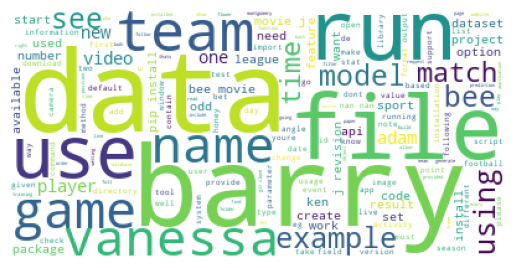

In [34]:
python_img = WordCloud(background_color='white').generate(' '.join (python_words))
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(python_img)
# axis aren't very useful for a word cloud
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

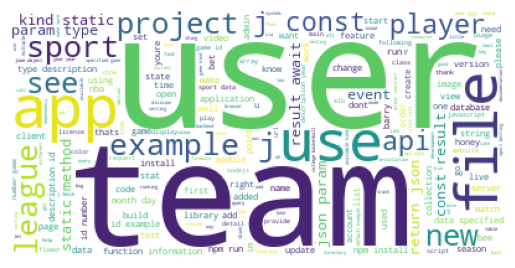

In [35]:
javascript_img = WordCloud(background_color='white').generate(' '.join (javascript_words))
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(javascript_img)
# axis aren't very useful for a word cloud
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

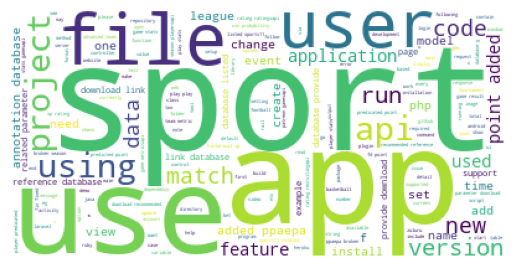

In [36]:
other_img = WordCloud(background_color='white').generate(' '.join (other_words))
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(other_img)
# axis aren't very useful for a word cloud
plt.axis('off')

Text(0.5, 1.0, 'Proportion of the 20 most common words')

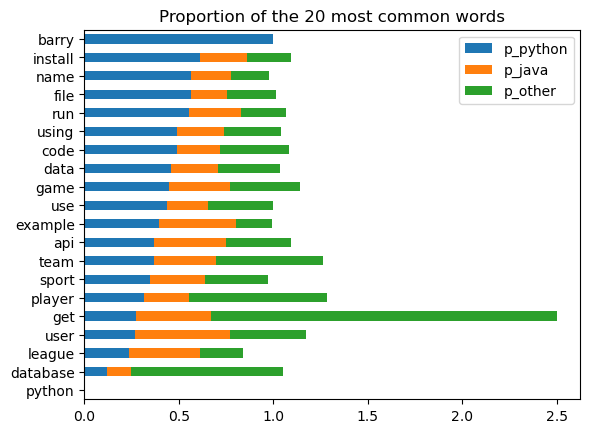

In [37]:

(word_counts
 .assign(p_python=word_counts.python / word_counts['all'],
         p_java=word_counts.javascript / word_counts['all'],
         p_other=word_counts.other / word_counts['all'])
 .sort_values(by='all')
 [['p_python', 'p_java', 'p_other']]
 .tail(20)
 .sort_values('p_python')
 .plot.barh(stacked=True))

plt.title('Proportion of the 20 most common words')

In [38]:
top_20_python_bigrams = (pd.Series(nltk.ngrams(python_words, 2))
                      .value_counts()
                      .head(20))

top_20_python_bigrams.head()

(bee, movie)         131
(movie, j)           131
(j, revision)        131
(revision, 81307)    122
(pip, install)       113
dtype: int64

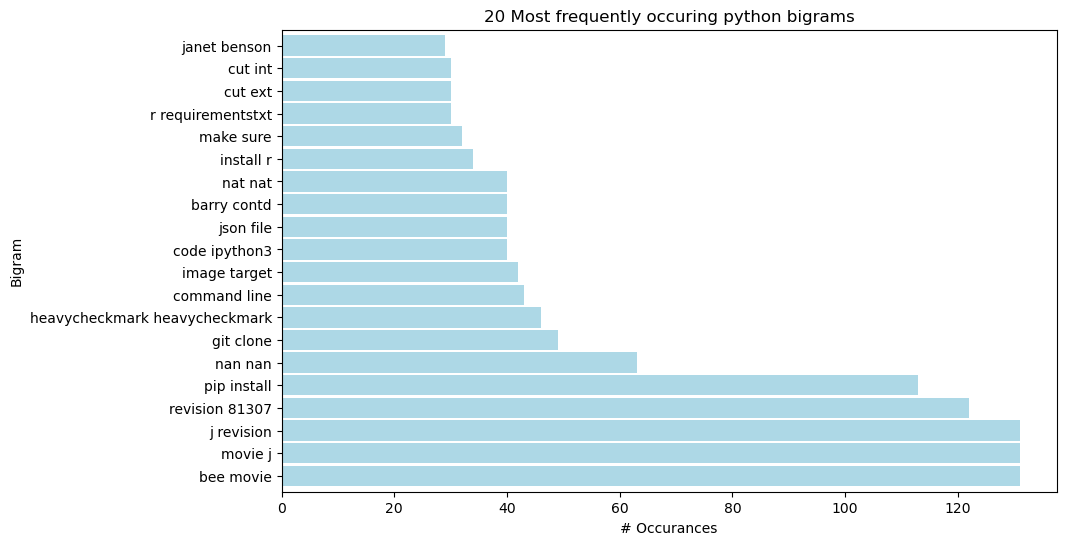

In [39]:
top_20_python_bigrams.sort_values(ascending=False).plot.barh(color='lightblue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring python bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_python_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


In [40]:
len(all_words)

155443

In [41]:
len(np.unique(all_words))

26456

In [42]:
df.readme_contents.str.split()

0      [AlphaPy, =======, |badge_pypi|, |badge_downlo...
1      [Latest, GitHub, version:, 11/4/2022,, v0.1.7,...
2      [#, nba, *Node.js, client, for, nba.com, API, ...
3      [#, NBA, Sports, Betting, Using, Machine, Lear...
4      [#, NBA, Player, Movements, This, is, a, scrip...
                             ...                        
989    [trackstatter, ---------, Track, your, Yahoo, ...
990    [#, EventProject, A, project, that, helps, tho...
992    [#, MLB-GameFeed-Bot, Add, to, your, server, w...
993    [#, court-booking-ddd, A, sample, application,...
995    [#, img-captioning-in-vietnamese, ##, Project,...
Name: readme_contents, Length: 743, dtype: object

In [43]:
dictionary = {'barry': 1, 'install': 1}

In [44]:
dictionary.keys()

dict_keys(['barry', 'install'])

In [45]:
if 'random' in dictionary.keys():
    
    dictionary['random'] += 1
    
dictionary

{'barry': 1, 'install': 1}

In [46]:
dictionary['no'] = 1


In [47]:
dictionary

{'barry': 1, 'install': 1, 'no': 1}

# Modeling

In [48]:
df['clean_text'] = df.readme_contents.apply(p.advanced_clean)

Removed 87 stopwords
---
Removed 813 stopwords
---
Removed 293 stopwords
---
Removed 92 stopwords
---
Removed 48 stopwords
---
Removed 951 stopwords
---
Removed 130 stopwords
---
Removed 305 stopwords
---
Removed 20 stopwords
---
Removed 0 stopwords
---
Removed 21 stopwords
---
Removed 20 stopwords
---
Removed 953 stopwords
---
Removed 470 stopwords
---
Removed 878 stopwords
---
Removed 104 stopwords
---
Removed 0 stopwords
---
Removed 62 stopwords
---
Removed 67 stopwords
---
Removed 10 stopwords
---
Removed 177 stopwords
---
Removed 20 stopwords
---
Removed 106 stopwords
---
Removed 62 stopwords
---
Removed 411 stopwords
---
Removed 83 stopwords
---
Removed 608 stopwords
---
Removed 754 stopwords
---
Removed 92 stopwords
---
Removed 48 stopwords
---
Removed 131 stopwords
---
Removed 356 stopwords
---
Removed 3 stopwords
---
Removed 213 stopwords
---
Removed 66 stopwords
---
Removed 69 stopwords
---
Removed 741 stopwords
---
Removed 100 stopwords
---
Removed 187 stopwords
---
Removed 

Removed 234 stopwords
---
Removed 154 stopwords
---
Removed 85 stopwords
---
Removed 183 stopwords
---
Removed 34 stopwords
---
Removed 3 stopwords
---
Removed 166 stopwords
---
Removed 0 stopwords
---
Removed 1 stopwords
---
Removed 70 stopwords
---
Removed 101 stopwords
---
Removed 685 stopwords
---
Removed 0 stopwords
---
Removed 34 stopwords
---
Removed 1 stopwords
---
Removed 64 stopwords
---
Removed 76 stopwords
---
Removed 5 stopwords
---
Removed 44 stopwords
---
Removed 62 stopwords
---
Removed 100 stopwords
---
Removed 254 stopwords
---
Removed 43 stopwords
---
Removed 0 stopwords
---
Removed 12 stopwords
---
Removed 164 stopwords
---
Removed 63 stopwords
---
Removed 31 stopwords
---
Removed 90 stopwords
---
Removed 124 stopwords
---
Removed 16 stopwords
---
Removed 192 stopwords
---
Removed 7 stopwords
---
Removed 121 stopwords
---
Removed 104 stopwords
---
Removed 32 stopwords
---
Removed 135 stopwords
---
Removed 17 stopwords
---
Removed 59 stopwords
---
Removed 109 stopwor

Removed 714 stopwords
---
Removed 55 stopwords
---
Removed 10 stopwords
---
Removed 2 stopwords
---
Removed 2 stopwords
---
Removed 12 stopwords
---
Removed 2 stopwords
---
Removed 23 stopwords
---
Removed 26 stopwords
---
Removed 3 stopwords
---
Removed 63 stopwords
---
Removed 0 stopwords
---
Removed 12 stopwords
---
Removed 164 stopwords
---
Removed 83 stopwords
---
Removed 1 stopwords
---
Removed 14 stopwords
---
Removed 181 stopwords
---
Removed 5 stopwords
---
Removed 233 stopwords
---
Removed 10 stopwords
---
Removed 160 stopwords
---
Removed 24 stopwords
---
Removed 12 stopwords
---
Removed 69 stopwords
---
Removed 8 stopwords
---
Removed 109 stopwords
---
Removed 147 stopwords
---
Removed 28 stopwords
---
Removed 45 stopwords
---
Removed 31 stopwords
---
Removed 22 stopwords
---
Removed 0 stopwords
---
Removed 193 stopwords
---
Removed 91 stopwords
---
Removed 1 stopwords
---
Removed 8 stopwords
---
Removed 63 stopwords
---
Removed 118 stopwords
---
Removed 29 stopwords
---


In [49]:
df['lemmas'] = df.readme_contents.apply(p.advanced_clean, l = True)

Removed 87 stopwords
---
Removed 813 stopwords
---
Removed 293 stopwords
---
Removed 92 stopwords
---
Removed 48 stopwords
---
Removed 951 stopwords
---
Removed 130 stopwords
---
Removed 305 stopwords
---
Removed 20 stopwords
---
Removed 0 stopwords
---
Removed 21 stopwords
---
Removed 20 stopwords
---
Removed 953 stopwords
---
Removed 470 stopwords
---
Removed 878 stopwords
---
Removed 104 stopwords
---
Removed 0 stopwords
---
Removed 62 stopwords
---
Removed 67 stopwords
---
Removed 10 stopwords
---
Removed 177 stopwords
---
Removed 20 stopwords
---
Removed 106 stopwords
---
Removed 62 stopwords
---
Removed 411 stopwords
---
Removed 83 stopwords
---
Removed 608 stopwords
---
Removed 754 stopwords
---
Removed 92 stopwords
---
Removed 48 stopwords
---
Removed 131 stopwords
---
Removed 356 stopwords
---
Removed 3 stopwords
---
Removed 213 stopwords
---
Removed 66 stopwords
---
Removed 69 stopwords
---
Removed 741 stopwords
---
Removed 100 stopwords
---
Removed 187 stopwords
---
Removed 

Removed 164 stopwords
---
Removed 63 stopwords
---
Removed 31 stopwords
---
Removed 90 stopwords
---
Removed 124 stopwords
---
Removed 16 stopwords
---
Removed 192 stopwords
---
Removed 7 stopwords
---
Removed 121 stopwords
---
Removed 104 stopwords
---
Removed 32 stopwords
---
Removed 135 stopwords
---
Removed 17 stopwords
---
Removed 59 stopwords
---
Removed 109 stopwords
---
Removed 58 stopwords
---
Removed 674 stopwords
---
Removed 16 stopwords
---
Removed 9 stopwords
---
Removed 4 stopwords
---
Removed 0 stopwords
---
Removed 123 stopwords
---
Removed 1 stopwords
---
Removed 17 stopwords
---
Removed 2 stopwords
---
Removed 45 stopwords
---
Removed 22 stopwords
---
Removed 91 stopwords
---
Removed 305 stopwords
---
Removed 49 stopwords
---
Removed 100 stopwords
---
Removed 78 stopwords
---
Removed 1 stopwords
---
Removed 1 stopwords
---
Removed 137 stopwords
---
Removed 2 stopwords
---
Removed 49 stopwords
---
Removed 66 stopwords
---
Removed 171 stopwords
---
Removed 278 stopwords

Removed 69 stopwords
---
Removed 8 stopwords
---
Removed 109 stopwords
---
Removed 147 stopwords
---
Removed 28 stopwords
---
Removed 45 stopwords
---
Removed 31 stopwords
---
Removed 22 stopwords
---
Removed 0 stopwords
---
Removed 193 stopwords
---
Removed 91 stopwords
---
Removed 1 stopwords
---
Removed 8 stopwords
---
Removed 63 stopwords
---
Removed 118 stopwords
---
Removed 29 stopwords
---


In [50]:
df.head()

,repo,language,readme_contents,clean_text,lemmas
0,ScottfreeLLC/AlphaPy,Python,AlphaPy\n=======\n\n|badge_pypi| |badge_downlo...,alphapy badgepypi badgedownloads badgedocs bad...,alphapy badgepypi badgedownloads badgedocs bad...
1,jalapic/engsoccerdata,R,"Latest GitHub version: 11/4/2022, v0.1.7\n\nN...",latest github version 1142022 v017 nov 2022 up...,latest github version 1142022 v017 nov 2022 up...
2,bttmly/nba,JavaScript,# nba\n*Node.js client for nba.com API endpoin...,nba nodejs client nbacom api endpoints npm ins...,nba nodejs client nbacom api endpoint npm inst...
3,kyleskom/NBA-Machine-Learning-Sports-Betting,Python,# NBA Sports Betting Using Machine Learning 🏀\...,nba sports betting using machine learning mach...,nba sport betting using machine learning machi...
4,linouk23/NBA-Player-Movements,Python,# NBA Player Movements\n\nThis is a script for...,nba player movements script visualization nba ...,nba player movement script visualization nba g...


In [51]:
train, val, test = pre.train_val_test(df, strat = 'language', stratify = True)

(520, 5) (111, 5) (112, 5)


In [52]:
train.head()

,repo,language,readme_contents,clean_text,lemmas
769,RaphaelTarita/JavaSportsClub-testengine,other,# JavaSportsClub-testengine\n\nA test engine f...,javasportsclubtestengine test engine sportsclu...,javasportsclubtestengine test engine sportsclu...
298,toddrob99/redball,Python,# redball\nCreated by Todd Roberts\n\nhttps://...,redball created todd roberts redball bot manag...,redball created todd robert redball bot manage...
286,IBM/tjbot-sports-buddy,JavaScript,[![Build Status](https://travis-ci.org/IBM/tjb...,build status watson tjbot tjbot watson discove...,build status watson tjbot tjbot watson discove...
165,GoldenCheetah/scikit-sports,Python,Scikit-sports\n=============\n\n.. image:: htt...,scikitsports image target image target image t...,scikitsports image target image target image t...
309,rakibdevs/covid19-laravel-api,other,## Laravel [Covid 19](https://rapidapi.com/api...,laravel covid 19 api packagist github stars gi...,laravel covid 19 api packagist github star git...


In [53]:
X_train, y_train = pre.xy_split(train)
X_val, y_val = pre.xy_split(val)
X_test, y_test = pre.xy_split(test)

In [54]:
X_train.shape, X_val.shape, X_test.shape

((520, 4), (111, 4), (112, 4))

In [55]:
X_train.head()

,repo,readme_contents,clean_text,lemmas
769,RaphaelTarita/JavaSportsClub-testengine,# JavaSportsClub-testengine\n\nA test engine f...,javasportsclubtestengine test engine sportsclu...,javasportsclubtestengine test engine sportsclu...
298,toddrob99/redball,# redball\nCreated by Todd Roberts\n\nhttps://...,redball created todd roberts redball bot manag...,redball created todd robert redball bot manage...
286,IBM/tjbot-sports-buddy,[![Build Status](https://travis-ci.org/IBM/tjb...,build status watson tjbot tjbot watson discove...,build status watson tjbot tjbot watson discove...
165,GoldenCheetah/scikit-sports,Scikit-sports\n=============\n\n.. image:: htt...,scikitsports image target image target image t...,scikitsports image target image target image t...
309,rakibdevs/covid19-laravel-api,## Laravel [Covid 19](https://rapidapi.com/api...,laravel covid 19 api packagist github stars gi...,laravel covid 19 api packagist github star git...


In [56]:
y_train.value_counts()

other         201
Python        162
JavaScript     99
R              30
TypeScript     28
Name: language, dtype: int64

In [57]:
 y_train.shape[0] * 100

52000

In [58]:
baseline_acc = y_train.value_counts().max() / y_train.shape[0] * 100

print(f'Baseline accuracy: {round(baseline_acc, 2)}.')

Baseline accuracy: 38.65.


In [59]:
tfidf = TfidfVectorizer()

X_train_tfidf = tfidf.fit_transform(X_train.lemmas)
X_val_tfidf = tfidf.transform(X_val.lemmas)
X_test_tfidf = tfidf.transform(X_test.lemmas)

X_train_tfidf[:10]

<10x23189 sparse matrix of type '<class 'numpy.float64'>'
	with 851 stored elements in Compressed Sparse Row format>

In [60]:
pd.DataFrame(X_train_tfidf.todense(), columns=tfidf.get_feature_names_out())


,00,0000,00001155,00021,00028,0008536,001,0010,0011472,001a57,...,zuluruversion,zum,zup,zur,zwiftinsider,zwiftmap,zwiftpower,zxing,zxvf,zz6flzrlvek6
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
516,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
517,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
518,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Logistic Regression

In [61]:
lm = LogisticRegression(class_weight = 'balanced')

lm.fit(X_train_tfidf, y_train)

LogisticRegression(class_weight='balanced')

In [62]:
y_train_res = pd.DataFrame({'actual': y_train,
                            'preds': lm.predict(X_train_tfidf)})

y_train_res.head()

,actual,preds
769,other,other
298,Python,Python
286,JavaScript,JavaScript
165,Python,Python
309,other,other


In [63]:
print(classification_report(y_train_res.actual, y_train_res.preds))

              precision    recall  f1-score   support

  JavaScript       0.98      1.00      0.99        99
      Python       0.98      1.00      0.99       162
           R       0.94      1.00      0.97        30
  TypeScript       1.00      1.00      1.00        28
       other       1.00      0.97      0.98       201

    accuracy                           0.99       520
   macro avg       0.98      0.99      0.99       520
weighted avg       0.99      0.99      0.99       520



In [64]:
y_val_res = pd.DataFrame({'actual': y_val,
                           'preds': lm.predict(X_val_tfidf)})

y_val_res.head()

,actual,preds
381,JavaScript,other
303,other,other
4,Python,Python
595,other,R
231,R,R


In [65]:
print(classification_report(y_val_res.actual, y_val_res.preds))

              precision    recall  f1-score   support

  JavaScript       0.44      0.38      0.41        21
      Python       0.73      0.69      0.71        35
           R       0.71      0.83      0.77         6
  TypeScript       0.50      0.17      0.25         6
       other       0.67      0.79      0.72        43

    accuracy                           0.65       111
   macro avg       0.61      0.57      0.57       111
weighted avg       0.64      0.65      0.64       111



# Random Forest

In [66]:
rf = RandomForestClassifier(class_weight = 'balanced')
rf.fit(X_train_tfidf, y_train)

RandomForestClassifier(class_weight='balanced')

In [67]:
y_train_res = pd.DataFrame({'actual': y_train,
                            'preds': rf.predict(X_train_tfidf)})

y_train_res.head()

,actual,preds
769,other,other
298,Python,Python
286,JavaScript,JavaScript
165,Python,Python
309,other,other


In [68]:
print(classification_report(y_train_res.actual, y_train_res.preds))

              precision    recall  f1-score   support

  JavaScript       1.00      1.00      1.00        99
      Python       1.00      1.00      1.00       162
           R       1.00      1.00      1.00        30
  TypeScript       1.00      1.00      1.00        28
       other       1.00      1.00      1.00       201

    accuracy                           1.00       520
   macro avg       1.00      1.00      1.00       520
weighted avg       1.00      1.00      1.00       520



In [69]:
y_val_res = pd.DataFrame({'actual': y_val,
                           'preds': rf.predict(X_val_tfidf)})

y_val_res.head()

,actual,preds
381,JavaScript,other
303,other,other
4,Python,other
595,other,other
231,R,R


In [70]:
print(classification_report(y_val_res.actual, y_val_res.preds))

              precision    recall  f1-score   support

  JavaScript       0.55      0.29      0.37        21
      Python       0.73      0.63      0.68        35
           R       1.00      0.33      0.50         6
  TypeScript       0.00      0.00      0.00         6
       other       0.59      0.93      0.72        43

    accuracy                           0.63       111
   macro avg       0.57      0.44      0.45       111
weighted avg       0.62      0.63      0.59       111



/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Decision Tree

In [71]:
dt = DecisionTreeClassifier(class_weight = 'balanced')
    
dt.fit(X_train_tfidf, y_train)

DecisionTreeClassifier(class_weight='balanced')

In [72]:
y_train_res = pd.DataFrame({'actual': y_train,
                            'preds': dt.predict(X_train_tfidf)})

y_train_res.head()

,actual,preds
769,other,other
298,Python,Python
286,JavaScript,JavaScript
165,Python,Python
309,other,other


In [73]:
print(classification_report(y_train_res.actual, y_train_res.preds))

              precision    recall  f1-score   support

  JavaScript       1.00      1.00      1.00        99
      Python       1.00      1.00      1.00       162
           R       1.00      1.00      1.00        30
  TypeScript       1.00      1.00      1.00        28
       other       1.00      1.00      1.00       201

    accuracy                           1.00       520
   macro avg       1.00      1.00      1.00       520
weighted avg       1.00      1.00      1.00       520



In [74]:
y_val_res = pd.DataFrame({'actual': y_val,
                           'preds': dt.predict(X_val_tfidf)})

y_val_res.head()

,actual,preds
381,JavaScript,other
303,other,other
4,Python,JavaScript
595,other,R
231,R,other


In [75]:
print(classification_report(y_val_res.actual, y_val_res.preds))

              precision    recall  f1-score   support

  JavaScript       0.35      0.38      0.36        21
      Python       0.68      0.43      0.53        35
           R       0.12      0.17      0.14         6
  TypeScript       0.29      0.33      0.31         6
       other       0.57      0.67      0.62        43

    accuracy                           0.50       111
   macro avg       0.40      0.40      0.39       111
weighted avg       0.52      0.50      0.50       111



# KNN

In [76]:
knn = KNeighborsClassifier(n_neighbors=5)
    
knn.fit(X_train_tfidf, y_train)

KNeighborsClassifier()

In [77]:
y_train_res = pd.DataFrame({'actual': y_train,
                            'preds': knn.predict(X_train_tfidf)})

y_train_res.head()

,actual,preds
769,other,other
298,Python,Python
286,JavaScript,JavaScript
165,Python,Python
309,other,other


In [78]:
print(classification_report(y_train_res.actual, y_train_res.preds))

              precision    recall  f1-score   support

  JavaScript       0.68      0.51      0.58        99
      Python       0.77      0.77      0.77       162
           R       0.58      0.23      0.33        30
  TypeScript       0.75      0.43      0.55        28
       other       0.67      0.86      0.76       201

    accuracy                           0.70       520
   macro avg       0.69      0.56      0.60       520
weighted avg       0.70      0.70      0.69       520



In [79]:
y_val_res = pd.DataFrame({'actual': y_val,
                           'preds': knn.predict(X_val_tfidf)})

y_val_res.head()

,actual,preds
381,JavaScript,other
303,other,other
4,Python,JavaScript
595,other,JavaScript
231,R,Python


In [80]:
print(classification_report(y_val_res.actual, y_val_res.preds))

              precision    recall  f1-score   support

  JavaScript       0.44      0.33      0.38        21
      Python       0.62      0.51      0.56        35
           R       1.00      0.50      0.67         6
  TypeScript       1.00      0.33      0.50         6
       other       0.57      0.81      0.67        43

    accuracy                           0.59       111
   macro avg       0.73      0.50      0.56       111
weighted avg       0.61      0.59      0.57       111

